In [20]:
import mne
import pandas as pd
from scipy.fft import fft, fftfreq, rfft, rfftfreq, rfftn 
import numpy as np
import scipy
import matplotlib.pyplot as plt 
import os

In [2]:
def create_raw_object(file_path):
    # Creating the raw edf object using mne library  
    return mne.io.read_raw_edf(file_path)

In [3]:
def visualize_data(raw_object, duration_sec, start_time, eeg_color):
    # Plotting the EEG data   
    raw_object.plot(duration=duration_sec, start=start_time, color=dict(mag='black', grad='b', eeg=eeg_color, eog='k', ecg='m',
     emg='k', ref_meg='steelblue', misc='k', stim='k',
     resp='k', chpi='k'), bad_color="maroon")

In [7]:
def xlsx_to_df(file_path):
    train_seizures_timing = pd.read_excel(
        file_path,
        sheet_name='train',
        header=0,
        names=['Patient', 'Session', 'File', 'EEG Type', 'Normal/Abnormal', 'Filename', 'Start', 'Stop', 'Seizure Type'],
        usecols='C:F, I, L, M:O'
    )
    
    dev_seizures_timing = pd.read_excel(
        file_path,
        sheet_name='dev',
        header=0,
        names=['Patient', 'Session', 'File', 'EEG Type', 'Normal/Abnormal', 'Filename', 'Start', 'Stop', 'Seizure Type'],
        usecols='C:F, I, L, M:O'
    )
    
    
    return train_seizures_timing, dev_seizures_timing

In [10]:
def find_all_paths(path):
    # Goes into all possible directories starting from initial "path" 
    # goes into all sub-directories to find .edf files     
    list_of_files = {}
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            if filename.endswith(".edf"):
                list_of_files[filename] = os.sep.join([dirpath, filename])
    return list_of_files

In [24]:
def delete_unknown_files():
    to_delete = list(train_seizures_timing['Filename'][train_seizures_timing['EEG Type']=='Unknown']) + \
    list(dev_seizures_timing['Filename'][dev_seizures_timing['EEG Type']=='Unknown'])
    
    for file in to_delete:
        try:
            os.remove(f'edf{file[1:-3]}edf')
            os.remove(f'edf{file[1:]}')
            os.remove(f'edf{file[1:-3]}lbl')
            os.remove(f'edf{file[1:-3]}lbl_bi')
            os.remove(f'edf{file[1:]}_bi')
        except:
            pass

    print(to_delete)

In [25]:
delete_unknown_files()

['./train/02_tcp_le/069/00006904/s001_2010_08_20/00006904_s001_t000.tse', './train/02_tcp_le/056/00005672/s004_2009_07_13/00005672_s004_t001.tse', './train/02_tcp_le/004/00000499/s001_2003_09_30/00000499_s001_t006.tse', './train/02_tcp_le/004/00000418/s011_2009_01_26/00000418_s011_t000.tse', './train/02_tcp_le/079/00007952/s001_2011_07_25/00007952_s001_t001.tse', './train/02_tcp_le/009/00000906/s009_2009_07_27/00000906_s009_t000.tse', './train/02_tcp_le/009/00000906/s010_2009_08_10/00000906_s010_t000.tse', './train/02_tcp_le/028/00002881/s001_2006_04_21/00002881_s001_t000.tse', './train/02_tcp_le/028/00002806/s003_2004_12_28/00002806_s003_t000.tse', './train/02_tcp_le/022/00002236/s001_2004_12_02/00002236_s001_t000.tse', './train/02_tcp_le/020/00002051/s001_2004_02_26/00002051_s001_t001.tse', './train/02_tcp_le/068/00006811/s004_2010_07_30/00006811_s004_t000.tse', './train/02_tcp_le/027/00002752/s001_2006_04_10/00002752_s001_t000.tse', './train/02_tcp_le/011/00001113/s001_2004_01_16/00

In [8]:
train_seizures_timing, dev_seizures_timing = xlsx_to_df('_DOCS/seizures_v36r.xlsx')

In [9]:
train_seizures_timing.head()

,Patient,Session,File,EEG Type,Normal/Abnormal,Filename,Start,Stop,Seizure Type
0,NaN,NaN,NaN,NaN,NaN,Filename,Start,Stop,NaN
1,1402.0,s003,t001,Outpatient,Normal,./train/02_tcp_le/014/00001402/s003_2008_07_21...,NaN,NaN,NaN
2,1479.0,s001,t001,ICU,Abnormal,./train/02_tcp_le/014/00001479/s001_2004_06_14...,950.004,1047.02,FNSZ
3,1413.0,s001,t000,EMU,Abnormal,./train/02_tcp_le/014/00001413/s001_2004_07_13...,315.34,319.024,ABSZ
4,NaN,NaN,NaN,NaN,NaN,./train/02_tcp_le/014/00001413/s001_2004_07_13...,327.668,330.032,ABSZ


In [7]:
rawEDF = create_raw_object("edf_train_01_tcp_ar_000_00000077_s003_2010_01_21_00000077_s003_t000.edf")

Extracting EDF parameters from /home/sofiia/projects/EEG_disease/edf_train_01_tcp_ar_000_00000077_s003_2010_01_21_00000077_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [8]:
rawEDF.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 36 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2010-01-21 13:58:36 UTC
 nchan: 36
 projs: []
 sfreq: 250.0 Hz
>

In [9]:
def fast_fourier_transform(rawEDF, if_real_value=False):
    start, stop = rawEDF.time_as_index([100, 101])
    print(start, stop)
    data, times = rawEDF[:, start:stop]
    print(data.shape)
    
    if if_real_value is True:
        yf = fft(data[1])
        xf = fftfreq(250, 1 / 250)
    else:
        yf = rfft(data[1])
        xf = rfftfreq(250, 1 / 250)

    plt.plot(xf, np.abs(yf))
    plt.show()

25000 25250


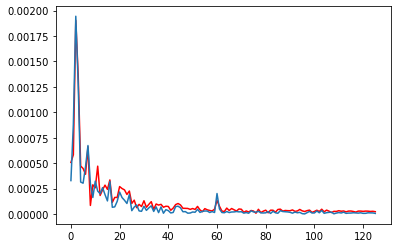

In [28]:
yf = rfftn(data).sum(axis=0) / len(data)
# normalized_yf = 
# len(yf)
# yf
xf = rfftfreq(250, 1 / 250)
plt.plot(xf, np.abs(yf), 'r')
plt.plot(rfftfreq(250, 1 / 250), np.abs(rfft(data[1])))
plt.show()